In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from dense_image_aligment import show_data, image_aligment_method, read_as_grayscale
from dense_image_aligment import save_aligment_progress, read_as_colored, show_data
from dense_image_aligment.transformations import AffineTransformation

import cv2

In [2]:
def create_simple_gauss(mu, sigma, shape):
    x = np.linspace(0, 1, shape[0])
    y = np.linspace(0, 1, shape[1])
    
    xx, yy = np.meshgrid(x, y, indexing='xy')
    
    z = np.exp(-( (xx - mu[0])**2 / (sigma[0]**2) +  (yy - mu[1])**2 / (sigma[1]**2)) / 2) / (np.sqrt(sigma[0]**2 + sigma[1]**2) * np.sqrt(2 * np.pi))
    return z

In [3]:
template = create_simple_gauss([0.5, 0.5], [0.1, 0.1], [100, 100])
image = create_simple_gauss([0.5, 0.5], [0.1, 0.1], [100, 100])

In [4]:
method, params = image_aligment_method(key='forward_additive')
params['alpha'] = 1.0
params['max_iterations'] = 1000
params['convergence_threshold'] = 1e-8
params['p_init'] = np.array(
    [
        [1, 0.1, 20], 
        [0.5, 1., -20.],
    ]
).reshape(-1)

transform = AffineTransformation(params['p_init'])

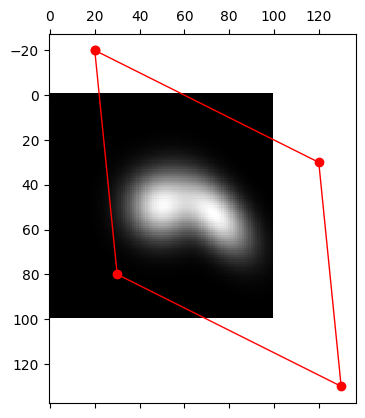

In [5]:
show_data(
    image=image, 
    template=template, 
    coords_transform=transform
)

In [6]:
ps = method(
    image=image,
    template=template,
    coord_transform=transform,
    **params
)

iteration: 999, |∇p|=0.00003: 100%|██████████| 1000/1000 [01:08<00:00, 14.56it/s]


In [7]:
ps[-1]

array([  0.96260394,  -0.36931489,  20.00144782,   0.48624704,
         0.91484286, -19.98934719])

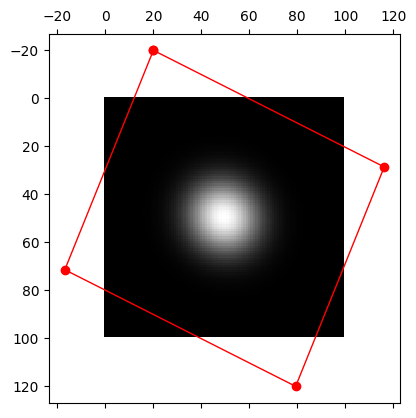

In [8]:
transform.p = ps[-1]

show_data(
    image=image, 
    template=template, 
    coords_transform=transform
)

100%|██████████| 50/50 [00:06<00:00,  8.14it/s]


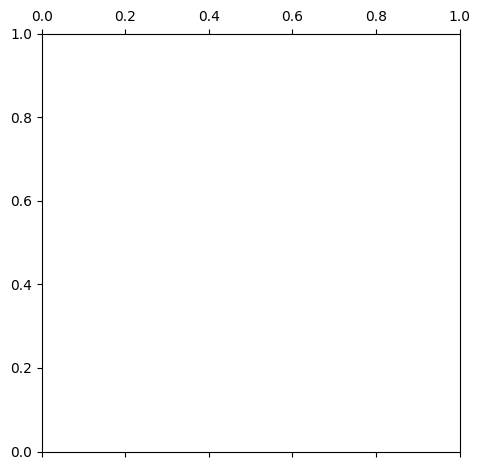

In [13]:
save_aligment_progress(
    f'../docs/images/affine_alignment_example.gif',
    image=image,
    template=template,
    coords_transform=transform,
    ps=ps[0:50],
    duration=200,
)

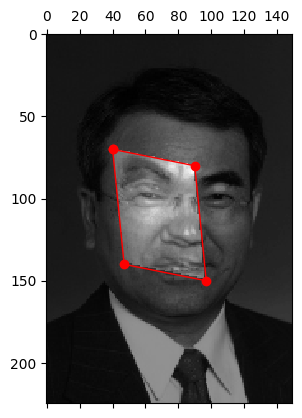

In [20]:
image = read_as_grayscale('./media/kanade_image.jpg')
template = read_as_grayscale('./media/kanade.jpg')


method, params = image_aligment_method(key='forward_additive')
params['alpha'] = 1.0
params['max_iterations'] = 1000
params['convergence_threshold'] = 1e-8
params['p_init'] = np.array(
    [
        [1, 0.1, 40], 
        [0.2, 1., 70.],
    ]
).reshape(-1)

affine_transform = AffineTransformation(params['p_init'].reshape(-1))

show_data(
    image=image, 
    template=template, 
    coords_transform=affine_transform
)

In [21]:
params['p_init'] = cv2.invertAffineTransform(params['p_init'].reshape(2, 3)).reshape(-1)
ps = method(
    image=template,
    template=image,
    coord_transform=affine_transform,
    **params
)

iteration: 999, |∇p|=0.00010: 100%|██████████| 1000/1000 [04:07<00:00,  4.04it/s]


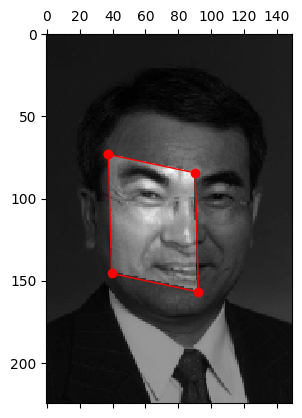

In [23]:
affine_transform.p = cv2.invertAffineTransform(ps[-1].reshape(2, 3)).reshape(-1)

show_data(
    image=image, 
    template=template, 
    coords_transform=affine_transform
)